1. 데이터 준비
* 20%를 테스트 데이터로 80%를 학습용 데이터로 나눔
* 랜덤시드를 42로 고정해놓음, 재현성을 위해 사용함
* 모델 학습, 데이터 분할, 초기 가중치 등 여러 과정에서 랜덤이 사용되는데 이때 시드를 고정해놓으면 같은 결과를 얻을 수 있어 재현성 때문에 고정함

* 학습 데이터의 평균, 표준편차를 계산해서 Z-score 정규화

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# CSV 파일 바로 읽기
df = pd.read_csv("dataset/winequality-red.csv")

# 특징(X)과 타깃(y) 분리
X = df.drop("quality", axis=1).values
y = df["quality"].values

# train/test split (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# z-score 정규화
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


2. Linear Regression
* 독립 변수(X)와 종속 변수(y) 사이의 선형 관계를 모델링하는 가장 기본적인 회귀 기법
* MSE(Mean Squared Error)를 최소화하는 β 값을 찾는 것이 목표

* 수식: $ y = β0 + β1*x1 + β2*x2 + ... + βp*xp + ε $
* y: 예측하려는 값 (타깃), x1, x2, ..., xp: 입력 특징(feature), β0: 절편(bias), β1, β2, ..., βp: 계수(weights), ε: 오차(residual)

* 정규방정식 수식: $ β = (X^T * X)^-1 * X^T * y $
* 정규방정식을 통해 MSE를 최소화하는 최적의 계수 β를 계산할 수 있음

* MSE 수식: $ MSE = (1/n) * Σ (yi - ŷi)^2 $
* yi: 실제 값, ŷi: 예측 값, n: 샘플 수
* RMSE는 MSE의 제곱근

* $ R^2 $ 수식: $ R2 = 1 - (Σ (yi - ŷi)^2) / (Σ (yi - ȳ)^2) $
* yi: 실제 값, ŷi: 예측 값, ȳ: 실제 값의 평균, Σ: 모든 샘플 합
* 모델이 타깃 변동을 얼마나 설명하는지 나타내는 지표로, 1에 가까울수록 설명력이 높음

In [2]:
# Linear Regression 모델
# X_train에 bias 항 추가 (절편)
# bias 절편을 행렬 연산에 포함시키기 위해 1을 추가함
X_train_bias = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
X_test_bias = np.hstack([np.ones((X_test.shape[0], 1)), X_test])

# 정규방정식으로 계수 계산
beta = np.linalg.inv(X_train_bias.T @ X_train_bias) @ X_train_bias.T @ y_train

# 예측
y_pred_lr = X_test_bias @ beta

# 평가
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print(f"RMSE: {rmse_lr:.4f}, R2: {r2_lr:.4f}")

RMSE: 0.6245, R2: 0.4032


3. Decision Tree
* 입력 특징(feature)에 따라 데이터를 여러 조건으로 나누어 예측을 수행하는 트리 구조의 모델
* 데이터 분할 기준: 특징 값(feature)과 임계값(threshold)
* 트리의 각 노드에서 조건을 확인하고, 데이터를 왼쪽/오른쪽 자식으로 분할
* 최종 리프 노드에서는 타깃의 평균값을 예측값으로 사용

* 회귀용 Decision Tree에서는 노드 분할 기준이 MSE(Mean Squared Error)의 최소화
* 각 노드에서 분할할 때 왼쪽/오른쪽 그룹의 타깃 평균과 실제값 차이 제곱합이 최소가 되도록 선택

* 전체 데이터에서 모든 특징(feature)과 임계값(threshold)을 탐색
* MSE를 최소화하는 최적의 분할 선택
* 이 경우에는 트리가 데이터에 맞게 끝까지 성장하고, 샘플 2개 이상이면 노드 분할 가능하며 리프 노드 최소 1개 샘플이 기본 조건값임
* 리프 노드의 예측값 = 그 노드에 속한 y 값의 평균

In [3]:
# Decision Tree 모델
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)

y_pred_dt = dt_model.predict(X_test)

rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))
r2_dt = r2_score(y_test, y_pred_dt)

print(f"RMSE: {rmse_dt:.4f}, R2: {r2_dt:.4f}")

RMSE: 0.7826, R2: 0.0627


4. Random Forest
* Decision Tree를 여러 개 조합해 만든 앙상블 학습 모델
* 다수의 트리를 학습하고, 예측값의 평균을 사용
* 각 트리는 학습 데이터를 중복 허용 랜덤 샘플로 학습하는 Bagging 기법 사용
* Random Feature 선택하므로 각 노드 분할 시 일부 특징만 고려해 트리 간 상관 감소해서 과적합 방지됨

* 이 코드에서는 트리 100개를 만듦
* 노드 분할 시 일부 특징만 랜덤 선택하고 Decision Tree처럼 MSE 기준으로 분할하며 학습함

In [4]:
# Random Forest 모델
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"RMSE: {rmse_rf:.4f}, R2: {r2_rf:.4f}")

RMSE: 0.5483, R2: 0.5399


5. XGBoost
* Gradient Boosting 기반의 강력한 앙상블 모델
* 여러 Decision Tree를 순차적으로 학습
* 이전 트리의 오차를 다음 트리가 학습하도록 구성되어 있고, 이를 기반으로 예측값 업데이트함
* Gradient Boosting 방식으로 점진적으로 오차를 줄이는 방식

* 트리 100개 사용하고 있고, 각 트리가 예측에 기여하는 비율은 0.1로 설정되어 있음 (낮으면 학습 안정적)
* 각 트리의 예측값 합산 후 학습률 곱하여 최종 예측값 도출

In [5]:
# XGBoost 모델
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"RMSE: {rmse_xgb:.4f}, R2: {r2_xgb:.4f}")

RMSE: 0.5853, R2: 0.4758


6. DNN
* 학습 데이터에서 20%를 validation 데이터로 분리해 EarlyStopping과 모델 튜닝에 사용함
* 64->32->1개의 뉴런으로 모델 층을 순차적으로 쌓음

* ReLU 활성화 함수 사용
* 수식: $ ReLU(x) = max(0, x) $
* 입력값이 0보다 크면 그대로 출력, 0 이하이면 0으로 출력함
* 비선형함수로 DNN 학습 가능하고, max값 계산이 단순해 빠른 학습이 가능하며 Vanishing Gradient 문제 완화에 적합함
* 입력이 계속 0 이하이면 gradient가 0이라 Dead Neuron 문제 발생 가능함
* 이러한 경우 입력이 0 이하일 때 아주 작은 값을 부여하는 Leaky ReLU나 음수일 때도 연산 가능한 Parametric ReLU를 사용함

* Optimizer는 adam 사용
* Gradient Descent의 변형 중 하나로, 학습률을 자동으로 조절하면서 빠르고 안정적으로 학습 가능
* 기울기 1차 모멘트 계산을 통해 과거 gradient 평균을 기반으로 방향 안정화함
* 기울기 2차 모멘트 계산을 통해 과거 gradient 제곱 평균을 기반으로 학습률 조정함

* 10 epoch 동안 개선 없으면 학습 종료하고 최적 성능 epoch의 가중치로 복원하는 Early Stopping 사용
* 과적합 방지 및 불필요한 학습 시간을 줄이는 데 유용함

* 학습 데이터를 배치 크기 32로 나눠 순차적 학습
* 학습 중 검증 데이터 MSE 확인해 개선 없으면 조기 종료함

In [6]:
# DNN 모델
# train에서 20%를 validation으로 사용
X_train_dnn, X_val_dnn, y_train_dnn, y_val_dnn = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# DNN 모델 정의
dnn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])

dnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 학습
history = dnn_model.fit(
    X_train_dnn, y_train_dnn,
    validation_data=(X_val_dnn, y_val_dnn),
    epochs=200,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0
)

# 예측
y_pred_dnn = dnn_model.predict(X_test).flatten()

rmse_dnn = mean_squared_error(y_test, y_pred_dnn, squared=False)  # RMSE
r2_dnn = r2_score(y_test, y_pred_dnn)

print(f"RMSE: {rmse_dnn:.4f}, R2: {r2_dnn:.4f}")

10/10 [==============================] - 0s 2ms/step
RMSE: 0.6231, R2: 0.4059


In [7]:
# Random Forest > XGBoost > Linear Regression > DNN > Decision Tree

results = pd.DataFrame({
    "Model": ["Linear Regression", "Decision Tree", "Random Forest", "XGBoost", "DNN"],
    "RMSE": [round(rmse_lr, 4), round(rmse_dt, 4), round(rmse_rf, 4), round(rmse_xgb, 4), round(rmse_dnn, 4)],
    "R2":   [round(r2_lr, 4),   round(r2_dt, 4),   round(r2_rf, 4),   round(r2_xgb, 4),   round(r2_dnn, 4)]
})

print(results)

               Model    RMSE      R2
0  Linear Regression  0.6245  0.4032
1      Decision Tree  0.7826  0.0627
2      Random Forest  0.5483  0.5399
3            XGBoost  0.5853  0.4758
4                DNN  0.6231  0.4059


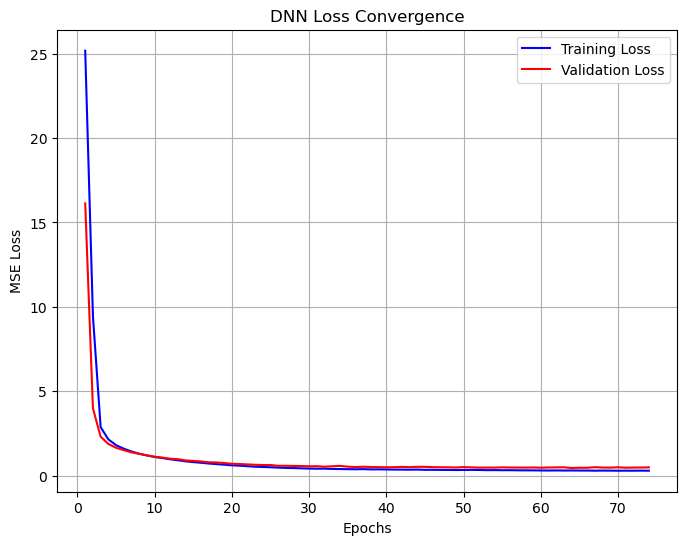

In [8]:
# DNN 학습 시 loss 수렴 그래프

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('DNN Loss Convergence')
plt.legend()
plt.grid(True)
plt.show()

+@ DNN 모델 성능 개선

- K-fold (데이터 수가 적음)
- 학습률 낮추기 + ReduceLROnPlateau 사용
- 은닉층/노드 수 증가 + Dropout 추가

In [9]:
#k-fold

from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_list = []
r2_list = []

for fold, (train_index, val_index) in enumerate(kf.split(X_train), 1):
    X_train_dnn, X_val_dnn = X_train[train_index], X_train[val_index]
    y_train_dnn, y_val_dnn = y_train[train_index], y_train[val_index]
    
    # 모델 정의
    dnn_model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    dnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    # Early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # 학습
    history = dnn_model.fit(
        X_train_dnn, y_train_dnn,
        validation_data=(X_val_dnn, y_val_dnn),
        epochs=200,
        batch_size=32,
        callbacks=[early_stop],
        verbose=0
    )
    
    # 예측
    y_pred_dnn = dnn_model.predict(X_test).flatten()
    
    rmse = mean_squared_error(y_test, y_pred_dnn, squared=False)
    r2 = r2_score(y_test, y_pred_dnn)
    
    rmse_list.append(rmse)
    r2_list.append(r2)
    
    print(f"Fold {fold} - RMSE: {rmse:.4f}, R2: {r2:.4f}")

print(f"\nAverage RMSE: {np.mean(rmse_list):.4f}, Average R2: {np.mean(r2_list):.4f}")


10/10 [==============================] - 0s 2ms/step
Fold 1 - RMSE: 0.6065, R2: 0.4371
10/10 [==============================] - 0s 1ms/step
Fold 2 - RMSE: 0.6161, R2: 0.4192
10/10 [==============================] - 0s 1ms/step
Fold 3 - RMSE: 0.6179, R2: 0.4157
10/10 [==============================] - 0s 2ms/step
Fold 4 - RMSE: 0.6362, R2: 0.3807
10/10 [==============================] - 0s 1ms/step
Fold 5 - RMSE: 0.6151, R2: 0.4211

Average RMSE: 0.6184, Average R2: 0.4148


In [10]:
# 학습률 낮추기 + ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 학습률 낮추기
optimizer = Adam(learning_rate=0.0005)  # 기본 0.001보다 낮게 설정

# DNN 모델 정의
dnn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])

dnn_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,          # 학습률을 절반으로 줄임
    patience=5,          # 5 epoch 동안 개선 없으면 감소
    min_lr=1e-6,         # 최소 학습률
    verbose=0
)

# 학습
history = dnn_model.fit(
    X_train_dnn, y_train_dnn,
    validation_data=(X_val_dnn, y_val_dnn),
    epochs=200,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=0
)

# 예측
y_pred_dnn = dnn_model.predict(X_test).flatten()

rmse_dnn = mean_squared_error(y_test, y_pred_dnn, squared=False)  # RMSE
r2_dnn = r2_score(y_test, y_pred_dnn)

print(f"RMSE: {rmse_dnn:.4f}, R2: {r2_dnn:.4f}")


10/10 [==============================] - 0s 2ms/step
RMSE: 0.6295, R2: 0.3937


In [11]:
# 은닉층/노드 수 증가
X_train_dnn, X_val_dnn, y_train_dnn, y_val_dnn = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# DNN 모델 정의 (은닉층 노드 수 128, 64)
dnn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1)
])

dnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 학습
history = dnn_model.fit(
    X_train_dnn, y_train_dnn,
    validation_data=(X_val_dnn, y_val_dnn),
    epochs=200,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0
)

# 예측
y_pred_dnn = dnn_model.predict(X_test).flatten()

rmse_dnn = mean_squared_error(y_test, y_pred_dnn, squared=False)  # RMSE
r2_dnn = r2_score(y_test, y_pred_dnn)

print(f"RMSE: {rmse_dnn:.4f}, R2: {r2_dnn:.4f}")


10/10 [==============================] - 0s 2ms/step
RMSE: 0.5942, R2: 0.4597


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_list = []
r2_list = []

for fold, (train_index, val_index) in enumerate(kf.split(X_train), 1):
    X_train_dnn, X_val_dnn = X_train[train_index], X_train[val_index]
    y_train_dnn, y_val_dnn = y_train[train_index], y_train[val_index]
    
    # 학습률 낮추기
    optimizer = Adam(learning_rate=0.0005)

    # DNN 모델 정의 (은닉층 노드 수 128, 64)
    dnn_model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    dnn_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    # Early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # ReduceLROnPlateau
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=0
    )
    
    # 학습
    history = dnn_model.fit(
        X_train_dnn, y_train_dnn,
        validation_data=(X_val_dnn, y_val_dnn),
        epochs=200,
        batch_size=32,
        callbacks=[early_stop, reduce_lr],
        verbose=0
    )
    
    # 예측
    y_pred_dnn = dnn_model.predict(X_test).flatten()
    
    rmse = mean_squared_error(y_test, y_pred_dnn, squared=False)
    r2 = r2_score(y_test, y_pred_dnn)
    
    rmse_list.append(rmse)
    r2_list.append(r2)
    
    print(f"Fold {fold} - RMSE: {rmse:.4f}, R2: {r2:.4f}")

print(f"\nAverage RMSE: {np.mean(rmse_list):.4f}, Average R2: {np.mean(r2_list):.4f}")


10/10 [==============================] - 0s 2ms/step
Fold 1 - RMSE: 0.6161, R2: 0.4192
10/10 [==============================] - 0s 2ms/step
Fold 2 - RMSE: 0.5915, R2: 0.4647
10/10 [==============================] - 0s 2ms/step
Fold 3 - RMSE: 0.6127, R2: 0.4256
10/10 [==============================] - 0s 1ms/step
Fold 4 - RMSE: 0.6099, R2: 0.4309
10/10 [==============================] - 0s 493us/step
Fold 5 - RMSE: 0.6009, R2: 0.4475

Average RMSE: 0.6062, Average R2: 0.4376
